In [50]:
import pandas as pd
import requests
import json
import matplotlib.pyplot as plt
import numpy as np
import statistics
import config
import datetime
import boto3
import math

In [51]:
CONFIG = config.get_config()
dtypes = config.get_types_of_attributes()
s3_resource = boto3.resource('s3')

In [52]:
sample_n=1000

In [53]:
prefix = 'tsv/etl/imp-pred-service-v1/imppredservice_training_data'
day = str( datetime.date.today() - datetime.timedelta(2) )
_prefix = '{}/d={}/'.format(prefix, day)
files= [ obj.key for obj in s3_resource.Bucket(CONFIG['S3_BUCKET']).objects.filter(Prefix=_prefix).all() if obj.key.endswith('.gz') ]

In [54]:
df = pd.concat((pd.read_csv('s3://{}/{}'.format(CONFIG['S3_BUCKET'], files[i]), sep=CONFIG['CSV_SEPARATOR'], compression='gzip', na_values=["null", "\\N"], dtype=dtypes) for i in range(sample_n//100)))

In [55]:
positive = df[df['imp_6'] == 1]
negative = df[df['imp_6'] == 0]

In [56]:
positive.columns

Index(['deliveryid', 'dayofweek', 'hour', 'pub_sspid', 'pub_accountid',
       'pub_as_siteid', 'pub_as_adspaceid', 'pub_as_domain', 'pub_as_pageurl',
       'pub_as_dimensions', 'pub_as_viewrate', 'pub_as_position',
       'pub_as_caps', 'req_buymodel', 'req_auctiontype', 'device_os',
       'device_model', 'rtb_ctr', 'rtb_viewrate', 'rtb_bidfloor', 'rtb_battr',
       'rtb_tagid', 'user_ip', 'user_market', 'user_city', 'ad_imptype',
       'req_bid', 'price', 'advcostcpm', 'won', 'targetbid', 'click', 'imp',
       'imp_0', 'imp_1', 'imp_2', 'imp_3', 'imp_4', 'imp_5', 'imp_6', 'imp_7',
       'imp_8', 'imp_9', 'imp_10', 'imp_11', 'imp_12', 'imp_13', 'imp_14'],
      dtype='object')

In [57]:
def make_request(instance):
    dayofweek_hour = int(instance['dayofweek']) * 24 + int(instance['hour'])
    day = int(instance['dayofweek'])
    hour = int(instance['hour'])
    
#     domain_position = str(instance['domain_position'])
    domain = str(instance['pub_as_domain'])
    position = 0 if math.isnan(float(instance['pub_as_position'])) else int(instance['pub_as_position'])
    url = "http://prediction-api.widespace.com/v1/predict"
    payload = "{\n    \"requestId\" : 346,\n    " + "\"day\": " + str(day) + ",\n    " +"\"hour\": " + str(hour) + ",\n    " +"\"adspace\" : {\n        "+"\"sspid\" : " + str(instance['pub_sspid']) + ",\n        "+"\"adspaceid\" : " + str(instance['pub_as_adspaceid']) + ",\n        "+"\"domain\" : \"" + domain.lower() + "\",\n        "+"\"position\": \" " + str(position) + "  \",\n        "+"\"dims\": \"" + str(instance['pub_as_dimensions']) + "\"\n    },\n    "+"\"device\" : {\n        "+"\"os\" : \"" + str(instance['device_os']) + "\",\n        "+"\"model\" : \"" + str(instance['device_model']) + "\"\n    },\n    "+"\"user\" : {\n        "+"\"market\" : \"" + str(instance['user_market']) + "\",\n        "+"\"city\" : \"" + str(instance['user_city']).lower() + "\",\n        "+"\"ip\": \"" + str(instance['user_ip'])  + "\"\n    }\n}"
    headers = {
        'token': "zY92d9MNFjHdUAGX1cCIWQKmIzRD6Krz3WzMEmxM",
        'content-type': "application/json",
        'cache-control': "no-cache",
        'postman-token': "bd5dfcd8-a906-4399-c6df-32e50d99b321"
        }

    response = requests.request("POST", url, data=payload, headers=headers)
    result = json.loads(response.text)
    return result

In [58]:
compare_by_adspace = []
def make_prediction(rows):
    results = []
    global compare_by_adspace
    compare_by_adspace = []
    for index, row in rows.iterrows():
        result = make_request(row)
        if not 'imp' in result:
            print(result)
            break
#         print(result)
#         break
        compare_by_adspace.append({
            'view_rate': row['pub_as_viewrate'],
            'adspaceid': row['pub_as_adspaceid'],
            'probability': result['imp'][0]['prob']
        })
        results.append(result['imp'][0]['prob'])
    return results

In [59]:
print(len(positive))
print(len(negative))

3497
257928


In [60]:
positives = positive.sample(n=sample_n)
view_rates_p = positives['pub_as_viewrate']
positive_results=make_prediction(positives)
positive_accuracy = np.sum(np.array(positive_results) > 0.5) / len(positives)
print("Accuracy in positive sample {}".format(positive_accuracy))

Accuracy in positive sample 0.536


In [61]:
negatives = negative.sample(n=sample_n)
view_rates_n = negatives['pub_as_viewrate']
negative_results=make_prediction(negatives)
negative_accuracy = np.sum(np.array(negative_results) > 0.5) / len(negatives)
print("Accuracy in negative sample {}".format(negative_accuracy))

Accuracy in negative sample 0.623


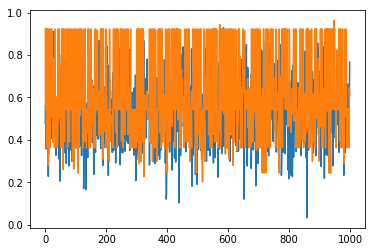

In [62]:
plt.plot(positive_results, label="Predicted")
plt.plot(view_rates_p.values, label="Based on adspace")

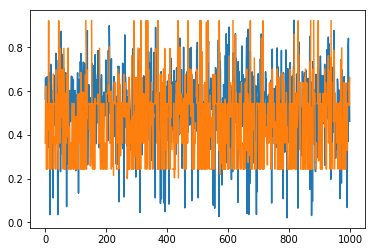

In [63]:
plt.plot(negative_results)
plt.plot(view_rates_n.values)

In [64]:
print("Positive")
print("Mean: {}".format(statistics.mean(positive_results)))
print("Std-dev: {}".format(statistics.stdev(positive_results)))
print("Negative")
print("Mean: {}".format(statistics.mean(negative_results)))
print("Std-dev {}".format(statistics.stdev(negative_results)))

Positive
Mean: 0.5244540706774
Std-dev: 0.14655749022759362
Negative
Mean: 0.5282099931666
Std-dev 0.1541090911687376


In [65]:
r = {}
for entry in compare_by_adspace:
    r[entry['adspaceid']] = { 'view_rate': [], 'probability': [] }
for entry in compare_by_adspace:
    r[entry['adspaceid']]['view_rate'].append(entry['view_rate'])
    r[entry['adspaceid']]['probability'].append(entry['probability'])

In [66]:
import numpy as np

n_r = []
for idr, rr in r.items():
    n_r.append({
        'adspaceid': idr,
        'avg_view_rate': np.mean(rr['view_rate']),
        'avg_probabilty': np.mean(rr['probability'])
    })
n_r

[{'adspaceid': '19774',
  'avg_view_rate': 0.36243377334770116,
  'avg_probabilty': 0.48293764660919536},
 {'adspaceid': '19892',
  'avg_view_rate': 0.5433470579954955,
  'avg_probabilty': 0.5384631511441441},
 {'adspaceid': '24374',
  'avg_view_rate': 0.623046875,
  'avg_probabilty': 0.448512197},
 {'adspaceid': '20791',
  'avg_view_rate': 0.5896420686141305,
  'avg_probabilty': 0.6642599786086956},
 {'adspaceid': '20979',
  'avg_view_rate': 0.24343287691156915,
  'avg_probabilty': 0.5930807088457448},
 {'adspaceid': '23679',
  'avg_view_rate': 0.434599609375,
  'avg_probabilty': 0.31343460372},
 {'adspaceid': '23947',
  'avg_view_rate': 0.4831478721217105,
  'avg_probabilty': 0.5251646135789474},
 {'adspaceid': '22234',
  'avg_view_rate': 0.92266845703125,
  'avg_probabilty': 0.42794106895833334},
 {'adspaceid': '21636',
  'avg_view_rate': 0.4241265190972222,
  'avg_probabilty': 0.40234558788888886},
 {'adspaceid': '22133',
  'avg_view_rate': 0.6389811197916667,
  'avg_probabilty': 0